# Differential Expression





Calculates differential expression between certain cell type and the rest of cells for the following quantities:

1. normalized mu1 
2. normalized mu2
3. normalized b (burst size)
4. normalized gamma (degradation rate) 


across all genes. 


Uses t-test that does not assume equal variance. 

In [23]:
# System
import sys

# Math
import numpy as np
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

# scvi
import anndata
import scanpy as sc


# stats
from scipy.stats import ttest_ind

-------

# Function for Differential Expression

In [190]:
def get_bursty_params(mu1,mu2,theta):
    ''' Returns b, beta, gamma of bursty distribution given mu1, mu2 and theta.
    Returns whatever size was input. 
    '''
    
    b = mu1/theta
    beta = 1/theta
    gamma = mu1/(mu2*theta)
    
    
    return(b,beta,gamma)

def perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',setup = 'Bursty-10-NAS_SHAPE',
                   alternative = ['two-sided','less','greater']):
    ''' Perform three ttests on genes in adata using parameters in results dict. 
    '''
    # define dictionaries to hold t and p values
    b_dict = {}
    gamma_dict = {}
    mu1_dict = {}
    mu2_dict = {}
    
    b_dict['genes'] = genes
    gamma_dict['genes'] = genes
    mu1_dict['genes'] = genes
    mu2_dict['genes'] = genes
    
    # define cluster labels
    cluster_labels = np.array(adata.obs[cluster_label].tolist())
    unique_clusters = np.unique(cluster_labels)
    adata_genes = adata.var['gene_name'].tolist()
    
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    
    # arrays to hold parameters
    b = np.ones((len(adata),len(genes)))
    gamma = np.ones((len(adata),len(genes)))
    mu1 = np.ones((len(adata),len(genes)))
    mu2 = np.ones((len(adata),len(genes)))

    
    # loop through genes and calculate parameters
    for i,g in enumerate(genes):
        index = adata_genes.index(g)
        mu1_ = np.array(results_dict['Bursty-10-NAS_SHAPE']['norm_means'])[:,index]
        mu2_ =  np.array(results_dict['Bursty-10-NAS_SHAPE']['norm_means'])[:,index+N]
        theta = results_dict[setup]['params']['dispersions'][:,index]
    
        b_,beta_,gamma_ = get_bursty_params(mu1_,mu2_,theta)
        b[:,i] = b_
        gamma[:,i] = gamma_
        
        mu1[:,i] = mu1_
        mu2[:,i] = mu2_
            
    for cl in unique_clusters:
        print(cl)
        # subset parameters
        b_cl = b[cluster_labels == cl,:]
        gamma_cl = gamma[cluster_labels == cl,:]
        mu1_cl = mu1[cluster_labels == cl,:]
        mu2_cl = mu2[cluster_labels == cl,:]
        
        b_rest = b[cluster_labels != cl,:]
        gamma_rest = gamma[cluster_labels != cl,:]
        mu1_rest = mu1[cluster_labels != cl,:]
        mu2_rest = mu2[cluster_labels != cl,:]
        
        # statistics for each parameters
        for alt in alternative:
            statistics_b, pvalues_b = ttest_ind(b_cl, b_rest, axis=0, equal_var= False, 
                              alternative=alt)
            statistics_gamma, pvalues_gamma = ttest_ind(gamma_cl, gamma_rest, axis=0, equal_var= False, 
                              alternative=alt)
            statistics_mu1, pvalues_mu1 = ttest_ind(mu1_cl, mu1_rest, axis=0, equal_var= False, 
                              alternative=alt)
            statistics_mu2, pvalues_mu2 = ttest_ind(mu2_cl, mu2_rest, axis=0, equal_var= False, 
                              alternative=alt)
        
            b_dict[f'{cl} t-value, {alt}'] = statistics_b
            gamma_dict[f'{cl} t-value, {alt}'] = statistics_gamma
            mu1_dict[f'{cl} t-value, {alt}'] = statistics_mu1
            mu2_dict[f'{cl} t-value, {alt}'] = statistics_mu2
            
            b_dict[f'{cl} p-value, {alt}'] = pvalues_b
            gamma_dict[f'{cl} p-value, {alt}'] = pvalues_gamma
            mu1_dict[f'{cl} p-value, {alt}'] = pvalues_mu1
            mu2_dict[f'{cl} p-value, {alt}'] = pvalues_mu2

    return(b_dict,gamma_dict,mu1_dict,mu2_dict)

Load in data. 


In [192]:
name = 'B08_processed_hv'
data_dir = '../../data/allen/'

# read in results file
results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()

# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata.var_names_make_unique()

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

In [193]:

#two sided test
genes = adata.var['gene_name'].tolist()
b_dict,gamma_dict,mu1_dict,mu2_dict = perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup = 'Bursty-10-NAS_SHAPE',alternative = ['two-sided','less','greater'])


# { ct : {b not in mu1,mu2: [] , gamma not in mu1,mu2 : [] }}

# cell type | cell type | 
# differentially expressed genes b| differentially expressed genes | 

# -- just a dictionary? pd needs same length




Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
SMC


<ipython-input-190-6819fbc4d430>:71: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistics_b, pvalues_b = ttest_ind(b_cl, b_rest, axis=0, equal_var= False,
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
<ipython-input-190-6819fbc4d430>:73: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistics_gamma, pvalues_gamma = ttest_ind(gamma_cl, gamma_rest, axis=0, equal_var= False,
<ipython-input-190-6819f

Sncg
Sst
VLMC
Vip
doublet


In [194]:
b_df = pd.DataFrame(b_dict)
gamma_df = pd.DataFrame(gamma_dict)
mu1_df = pd.DataFrame(mu1_dict)
mu2_df = pd.DataFrame(mu2_dict)

In [195]:
cluster_labels = np.unique(np.array(adata.obs['subclass_label'].tolist()))


# store significant differentially expressed genes
sig_dict = {ct : {} for ct in cluster_labels}

for ct in cluster_labels:
    
    print(ct)
    b_genes = list(b_df[b_df[f'{ct} p-value, two-sided'] < 0.025].genes)
    
    gamma_genes = list(gamma_df[gamma_df[f'{ct} p-value, two-sided'] < 0.025].genes)
    
    mu1_genes = list(mu1_df[mu1_df[f'{ct} p-value, two-sided'] < 0.025].genes)
    mu2_genes = list(mu2_df[mu2_df[f'{ct} p-value, two-sided'] < 0.025].genes)
    
    
    biVI_genes = [g for g in genes if (g in b_genes or g in gamma_genes) and (g not in mu1_genes and g not in mu2_genes)]
    scVI_genes = [g for g in genes if (g not in b_genes and g not in gamma_genes) and (g in mu1_genes or g in mu2_genes)]
    
    overlap_genes = [g for g in genes if (g in b_genes or g in gamma_genes) and (g in mu1_genes or g in mu2_genes)]
    
    sig_dict[ct]['b_genes'] = b_genes
    sig_dict[ct]['gamma_genes'] = gamma_genes
    sig_dict[ct]['mu1_genes'] = mu1_genes
    sig_dict[ct]['mu2_genes'] = mu2_genes
    sig_dict[ct]['biVI_genes'] = biVI_genes
    sig_dict[ct]['scVI_genes'] = scVI_genes
    sig_dict[ct]['overlap_genes'] = overlap_genes
    
    
    

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Macrophage
OPC
Oligo
Pvalb
SMC
Sncg
Sst
VLMC
Vip
doublet


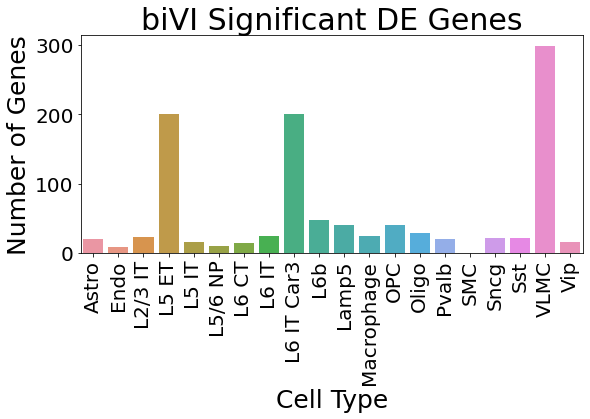

In [209]:
sig_gene_plot = []
sig_gene_scVI = 0
sig_gene_biVI = 0
sig_gene_overlap = 0

# on average per cell type? yeah, sure

for ct in cluster_labels:
    if ct != 'doublet':      
        sig_gene_plot.append(len(sig_dict[ct]['biVI_genes'])/2)
        sig_gene_biVI += len(sig_dict[ct]['biVI_genes'])
        sig_gene_scVI += len(sig_dict[ct]['scVI_genes'])
        sig_gene_overlap += len(sig_dict[ct]['overlap_genes'])
        
plt.figure(figsize=(9,4))
sns.barplot(x=cluster_labels[:-1],y = sig_gene_plot)
plt.xticks(rotation=90);
plt.xlabel('Cell Type',fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(f'biVI Significant DE Genes',fontsize = 30)
plt.ylabel('Number of Genes',fontsize = 25);
plt.savefig(f'../../results/{name}_figs/biVI_DE_genes.png',bbox_inches='tight')

In [200]:
print('biVI:', sig_gene_biVI/20)
print('scVI:', sig_gene_scVI/20)
print('overlap:', sig_gene_overlap/20)

biVI: 108.1
scVI: 109.5
overlap: 3487.0


In [220]:
for ct in cluster_labels:
    if 'Pter' in sig_dict[ct]['biVI_genes']:
        print(ct)


L6 IT Car3


In [222]:
sig_dict['Sst']['biVI_genes'][:int(len(sig_dict['L5 IT']['biVI_genes'])/2)+1]

['Cacng4',
 'Dcxr',
 'Tmem100',
 'Nfam1',
 'Cyp2d22',
 'Guca1a',
 'Gal',
 'Gcnt1',
 'Gm9895',
 'Gbp3',
 'Olfm3',
 'Notch2',
 'Lhx5',
 'Hspb8',
 'Parm1',
 'Garem2',
 'Nat8']

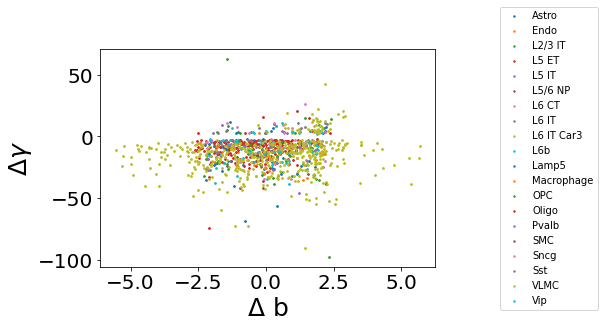

In [197]:
sig_biVI_b_t_val = {}
sig_biVI_gamma_t_val = {}

for ct in cluster_labels:
    if ct != 'doublet':
        genes_ = sig_dict[ct]['biVI_genes']
        sig_biVI_b_t_val[ct] = b_df[b_df['genes'].isin(genes_)][f'{ct} t-value, less']
        sig_biVI_gamma_t_val[ct] = gamma_df[gamma_df['genes'].isin(genes_)][f'{ct} t-value, two-sided']
        plt.scatter(sig_biVI_b_t_val[ct],sig_biVI_gamma_t_val[ct], label = f'{ct}',s=2)


        

#plt.xscale('log')
#plt.yscale('log')
#plt.figure(figsize=(9,6))

#plt.xticks(rotation=90);
plt.xlabel('$\Delta$ b',fontsize = 25)
plt.ylabel('$\Delta \gamma$',fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='center right',bbox_to_anchor=(1.5, 0.5))

#plt.savefig(f'../../results/{name}_figs/biVI_DE_genes.png',bbox_inches='tight')


    

------


# PCA of latent space




In [122]:
from sklearn.decomposition import PCA

In [127]:
cm = plt.get_cmap('rainbow')
clusters = adata.obs['subclass_label'].tolist()

#cell_range = range(len(cell_types.unique())) * 3
cluster_color_dict = {cl: cm(i*12) for i,cl in enumerate(cluster_labels)}

cluster_colors = np.array([cluster_color_dict[cl] for cl in clusters])

Wed Nov 16 08:56:45 2022 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


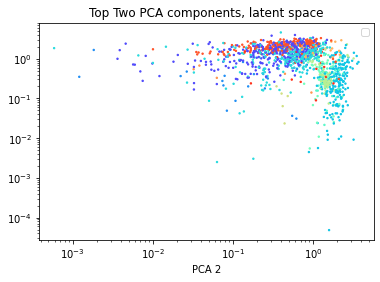

In [155]:
# declare PCA object


pca_x10 = PCA(n_components=10)
pca_x10.fit(results_dict['Bursty-10-NAS_SHAPE']['X_10'])

pca_x10 = pca_x10.transform(results_dict['Bursty-10-NAS_SHAPE']['X_10'])


plt.scatter(pca_x10[:,0],pca_x10[:,1],color=cluster_colors,s = 2)
plt.title('Top Two PCA components, latent space')
plt.xlabel('PCA 1')
plt.xlabel('PCA 2')
plt.xscale('log')
plt.yscale('log')
plt.legend()